In [0]:
!pip3 install sklearn progress iterative-stratification pandas
from sklearn.model_selection import train_test_split

In [0]:
!git clone https://github.com/sergioburdisso/pyss3.git

fatal: destination path 'pyss3' already exists and is not an empty directory.


In [0]:
from pyss3.pyss3.__init__ import SS3
from pyss3.pyss3.util import Dataset, membership_matrix, Evaluation, span
from pyss3.pyss3.server import Live_Test
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

from google.colab import drive
from sys import path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [0]:
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab'
path.append(path_root)
data_root = '/data'
# single_label_dir = '/SB1_Train-entity'

/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=67 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=68 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs


Mounted at /content/drive


In [0]:
multi_label_dir_test = '/Muneeb-Entity-Testing'
multi_label_dir_train = '/SB1_Train_Multilabel'


**LOADING DATA**

In [0]:
multi_text_train, multi_labels_train = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_train + '/entity-text.txt', path_root + data_root + multi_label_dir_train + '/entity-labels.txt', sep_label=';')
multi_text_test, multi_labels_test = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_test + '/entity-text.txt', path_root + data_root + multi_label_dir_test + '/entity-labels.txt', sep_label=';')

100%|██████████| 1161/1161 [00:00<00:00, 264005.80it/s]


**DATA FILTERING AND DATASET EXPLORATION**



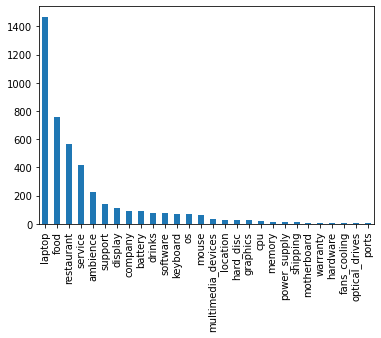

In [0]:
# CLASSES DISTRUBUTION

pd.Series([y for yy in multi_labels_train for y in yy]).value_counts().plot(kind ='bar')

In [0]:
def remove_classes(text, labels, restricted_labels):
  indexes = []
  for c,values in enumerate(labels):
    allowed_labels = [value for value in values if value not in restricted_labels]
    if len(allowed_labels):
      labels[c] = allowed_labels
    else:
      indexes.append(c)

  for index in sorted(indexes, reverse=True):
    del text[index]
    del labels[index]  

In [0]:
def top_classes_overlap(labels):
  all_classes = {}
  classes = list(set([y for yy in labels for y in yy]))
  for main_class in classes:
    Frequency = {}
    for label_list in labels:
      if main_class in label_list:
        keys = list(itertools.product([main_class], label_list))
        for key in keys:
          if key in Frequency:
            Frequency[key] = Frequency[key] + 1
          else:
            Frequency[key] = 1
    Frequency = {k: v for k, v in sorted(Frequency.items(), key=lambda item: item[1],reverse=True)}
    all_classes[main_class] = Frequency
  return all_classes

In [0]:
def false_negative_distribution(clf,category, x_val, y_val, def_cat):
  FN = {}
  Frequency = {}
  count = 0
  for c,labels in enumerate(y_val):
    if category in labels:
      predicted = clf.classify_multilabel(x_val[c], def_cat= def_cat)
      if category not in predicted:
        count += 1
        FN[x_val[c]] = predicted
        for label in predicted:
          if label in Frequency:
            Frequency[label] = Frequency[label] + 1
          else:
            Frequency[label] = 1
  
  print("# False Negative: ", count)
  Frequency = {k: v for k, v in sorted(Frequency.items(), key=lambda item: item[1],reverse=True)}
  plt.bar(Frequency.keys(), Frequency.values(), width=1, color='g')
  plt.xticks(rotation=90)
  plt.show()
  return [Frequency, FN]

In [0]:
!pip3 install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import download

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [0]:
from functools import reduce

def tokenize_samples(samples):
  return list(map(word_tokenize, samples))

def filter_stop_words(token_samples):
  return list(map(lambda x: [w for w in x if w not in stop_words], token_samples))

def clue_together(tokens):
  for index in range(len(tokens)):
    tokens[index] = reduce(lambda a,b: a+ " " + b, tokens[index], "")
  return tokens

X_tokenized = tokenize_samples(multi_text_train)
X_filtered = filter_stop_words(X_tokenized)
multi_text_train = clue_together(X_filtered)

In [0]:
remove_labels = ['hardware', 'ports', 'optical_drives', 'fans_cooling', 'warranty','motherboard']
remove_classes(multi_text_train, multi_labels_train, remove_labels)

**Train Test Split**


In [0]:
X_train, X_val, y_train, y_val = train_test_split(multi_text_train, multi_labels_train, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_fin, multi_labels_train, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111)

**CHANGE OPERATOR**

In [0]:
def dummy_summary_ops(cvs):
  return list(np.max(np.array(cvs), axis=0))

**PREDICTION AND EVALUATION**

Classification: 100%|██████████| 747/747 [00:01<00:00, 469.84it/s]



                    precision    recall  f1-score   support

            laptop       0.55      0.77      0.64       281
              food       0.84      0.67      0.74       165
          ambience       0.38      0.62      0.47        50
            drinks       0.50      0.57      0.53        14
        restaurant       0.48      0.42      0.45       109
          keyboard       0.42      0.80      0.55        10
           display       0.79      0.75      0.77        20
             mouse       0.78      0.58      0.67        12
           service       0.85      0.39      0.54        84
          location       0.75      0.38      0.50         8
           battery       0.56      0.91      0.69        11
         hard_disc       0.00      0.00      0.00         3
      power_supply       1.00      0.83      0.91         6
          software       0.71      0.42      0.53        12
           company       0.25      0.46      0.32        13
           support       0.50      0.5

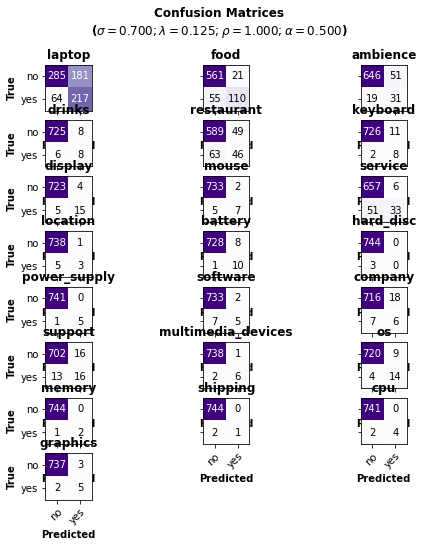

0.5947366359552998

In [0]:
clf = SS3(s=0.7, l=0.125, p=1, a=0.5) 
# clf.summary_op_ngrams = dummy_summary_ops
Evaluation.clear_cache(clf)
clf.train(X_train, y_train, n_grams=5)
Evaluation.test(clf, X_val, y_val,metric="f1-score", plot=True, cache=False)


**ANALYZING FALSE NEGATIVE**

# False Negative:  24


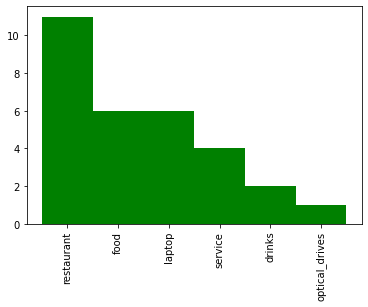

In [0]:
## def_cat = [''most-probable','unknown']
[num, text] = false_negative_distribution(clf, 'ambience', X_val, y_val, 'unknown')

In [0]:
print(text)

{'I have lived in Japan for 7 years and the taste of the food and the feel of the restaurant is like being back in Japan.': ['food', 'restaurant'], 'The service is good and ambience is good for a date or group outing.': ['service'], 'The in-house lady DJ on Saturday nights has outrageously good taste in music, and moreover, takes requests.': [], 'Although they do the typical what kind of water would you like questions the service was good and overall very relaxing to place to eat.': ['service', 'restaurant', 'drinks'], 'The characters really make for an enjoyable experience.': ['restaurant'], 'The pizza is yummy and I like the atmoshpere.': [], "I'll being with a couple of positives: cool decor, good pita and hummus, and grilled octopus that was actually pretty tasty.": [], "Quite simply it's like stepping out of Manhattan and into a haven of tranquility.": ['optical_drives'], 'The restaurant has a Family feel, not least with regard to the portions which are enormous; the veal alone co

In [0]:
# doc = ['I wish Toshiba would allow their customers to select an option that only boots the OS at setup and removes all the unnecessary stuff.']
# print('/n')
# print(clf.extract_insight(doc[0], cat='laptop', level='word', window_size=3, min_cv=0.01, sort=True))
# print(clf.predict_proba(x_test,prep=True, leave_pbar=True))
# print(clf.predict(x_test,prep=True, multilabel = True, leave_pbar=True))
# # clf.print_categories_info()
# # clf.print_model_info()
# # clf.print_ngram_info("cool laptop")


Classification: 100%|██████████| 1/1 [00:00<00:00, 250.54it/s]

/n
[]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5975799583942955, 0, 0.8943375011405222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[['hard_disc', 'os']]


**GRID SEARCH**

In [0]:
s_vals=span(0, 1, 11) 
l_vals=span(0, 1, 11)
p_vals=span(0,1,11)
a_vals=0.5

In [0]:
best_s, best_l, best_p, best_a = Evaluation.grid_search(
    clf 
    ,x_val 
    ,y_val
    # ,k_fold=3
    ,s=s_vals
    ,l=l_vals
    ,p=p_vals
    ,a=a_vals
    ,cache=False
    ,metric ="f1-score"
    ,n_grams = 5)


                    precision    recall  f1-score   support

           service       0.20      0.93      0.33        92
              food       0.29      0.95      0.45       158
            laptop       0.49      0.98      0.65       311
           support       0.10      0.92      0.19        26
        restaurant       0.22      0.87      0.35       110
          ambience       0.13      0.74      0.22        47
          warranty       0.00      0.00      0.00         3
          software       0.14      0.42      0.21        19
           battery       0.16      0.85      0.27        13
         hard_disc       0.12      0.33      0.18         3
          keyboard       0.10      0.50      0.17        10
           display       0.17      0.57      0.27        23
multimedia_devices       0.40      0.29      0.33         7
           company       0.16      0.80      0.26        20
                os       0.09      0.33      0.15        12
             mouse       0.06      0.2

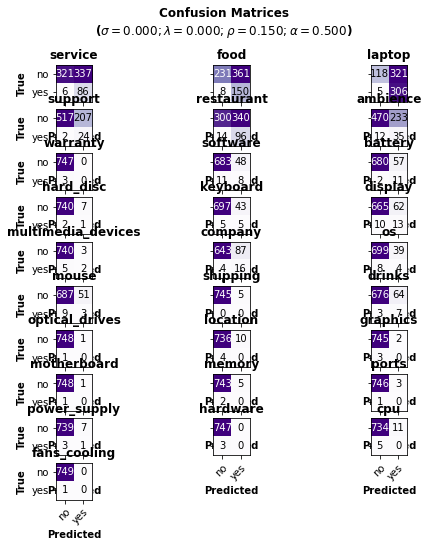

0.15961950772886951

In [0]:
print(best_s, best_l, best_p, best_a)

clf.set_hyperparameters(s=best_s, l=best_l, p=best_p, a=best_a)
Evaluation.test(clf, x_val, y_val, metric="f1-score", plot=True,cache=False)


In [0]:
## own implementation of grid search, check util.py for code

# from util import grid_search

# labels = list(set([y for yy in multi_labels_train for y in yy]))
# (best_s,best_l,best_p,best_a) = grid_search(clf,X_val,y_val, labels, metric = f1_score,s = s_vals,l = l_vals, p = p_vals, a= a_vals, **{"average":"macro","zero_division" : 0})


In [0]:
# clf.set_hyperparameters(s=best_s, l=best_l, p=best_p, a=best_a)
# Evaluation.test(clf, x_val, y_val, metric="f1-score", plot=True, def_cat="unknown", cache=False)

# **LIVE TEST**

In [0]:
#  Live_Test.run(clf, x_val, y_val)